In [45]:
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
import healpy as hp
from DS_healpix_fragmentation import radec2pix
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from gammapy.maps import Map, MapAxis, HpxGeom, WcsGeom
from tqdm.notebook import tqdm
import seaborn as sns
from DS_healpix_fragmentation import pix2radec

In [2]:
cats = {'pz_rot28' : pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv'),
        'pz_act_found2_22' : pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_act_found2_22_thr0.1_step8_no_fn.csv'),
        'pz_all_found34' : pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv') }

In [3]:
nside=2**9

In [4]:
for name in cats:
    df = cats[name]
    #sc = SkyCoord(ra=np.array(df['RA'])*u.degree, dec=np.array(df['DEC'])*u.degree, frame='icrs')
    #b = sc.galactic.b.degree
    #df = df[np.abs(b) > 15]
    #df.index = np.arange(len(df))
    df['pix'] = radec2pix(df['RA'], df['DEC'], nside)
    cats[name] = df

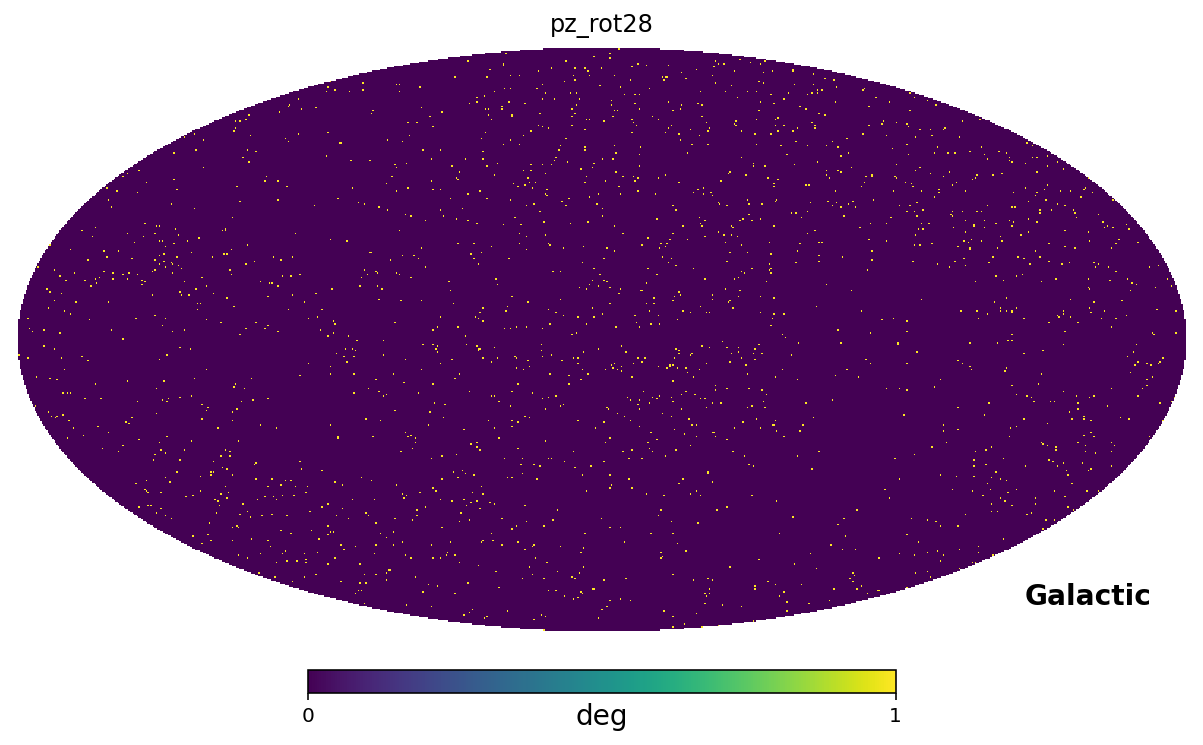

In [14]:
a = np.zeros(hp.nside2npix(nside), dtype=np.bool8)
a[cats['pz_rot28']['pix']] = 1
amap=hp.mollview(a, nest=True, title='pz_rot28', coord='G', return_projected_map=True, unit='deg')

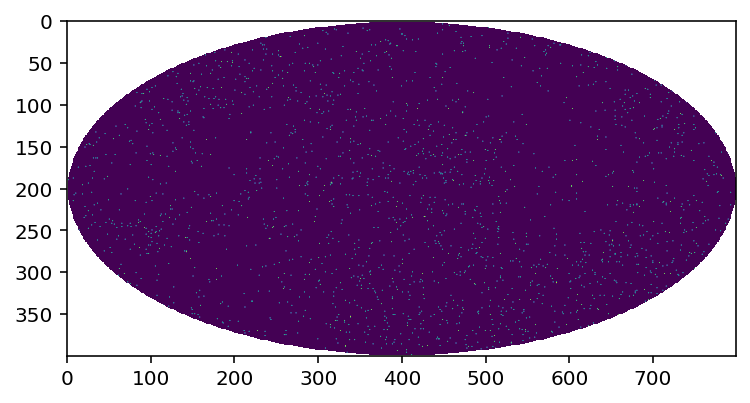

In [13]:
plt.imshow(amap)

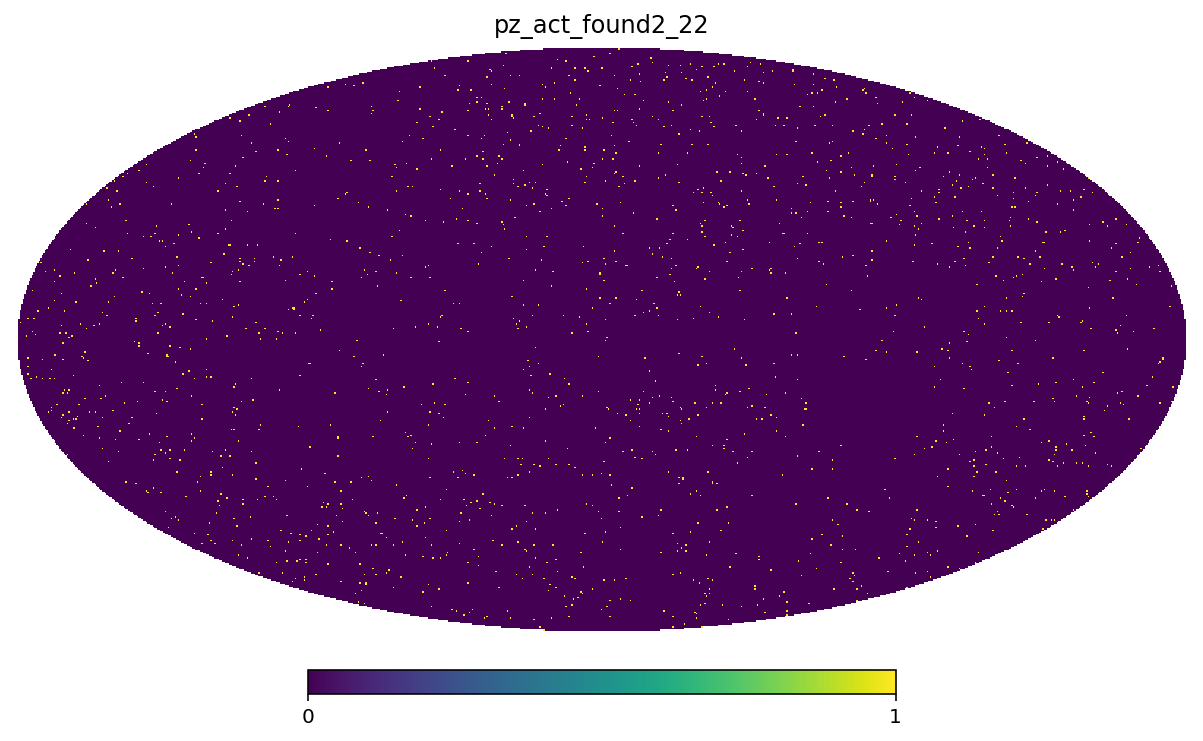

In [6]:
a = np.zeros(hp.nside2npix(nside), dtype=np.bool8)
a[cats['pz_act_found2_22']['pix']] = 1
hp.mollview(a, nest=True, title='pz_act_found2_22')

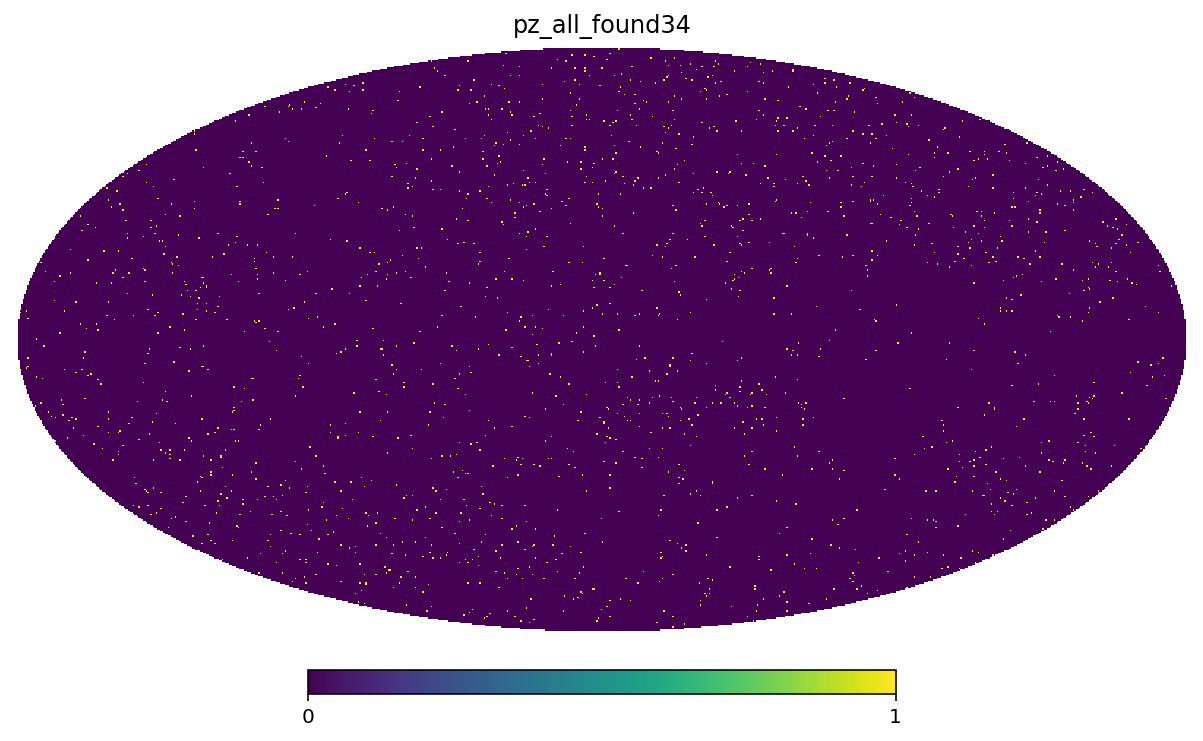

In [7]:
a = np.zeros(hp.nside2npix(nside), dtype=np.bool8)
a[cats['pz_all_found34']['pix']] = 1
hp.mollview(a, nest=True, title='pz_all_found34')

In [8]:
def plot_history(hist_file, loss_tick=None, cut_eps=[0, -1]):
    import pickle
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    
    hist = None
    with open(hist_file, 'rb') as f:
        hist = pickle.load(f)
        hist = pd.DataFrame(hist, index=np.arange(1, len(hist['loss']) + 1))
    _, ax = plt.subplots(2, 1, figsize=(10,14))
    
    hist = hist.iloc[cut_eps[0]:cut_eps[1]]
    
    line, = ax[0].plot(hist.index, hist['loss'], 'co-')
    line.set_label('loss')
    line, = ax[0].plot(hist.index, hist['val_loss'], 'co-', alpha=0.5)
    line.set_label('val_loss')
    
    for c, metr in zip('rb', ['iou', 'dice']):
        line, = ax[1].plot(hist.index, hist[metr], c+'o-')
        line.set_label(metr)
        line, = ax[1].plot(hist.index, hist['val_'+metr], c+'o-', alpha=0.5)
        line.set_label('val_'+metr)
    
    for i in range(2):
        ax[i].legend()
        ax[i].set_xticks(hist.index, minor=True)
        ax[i].set_xticks(hist.index[4::5])
        ax[i].grid(True, axis='both', which='major')
        ax[i].grid(True, axis='both', which='minor', alpha=0.2)
    if not (loss_tick is None):
        ax[0].set_yticks(loss_tick[::5])
        ax[0].set_yticks(loss_tick, minor=True)


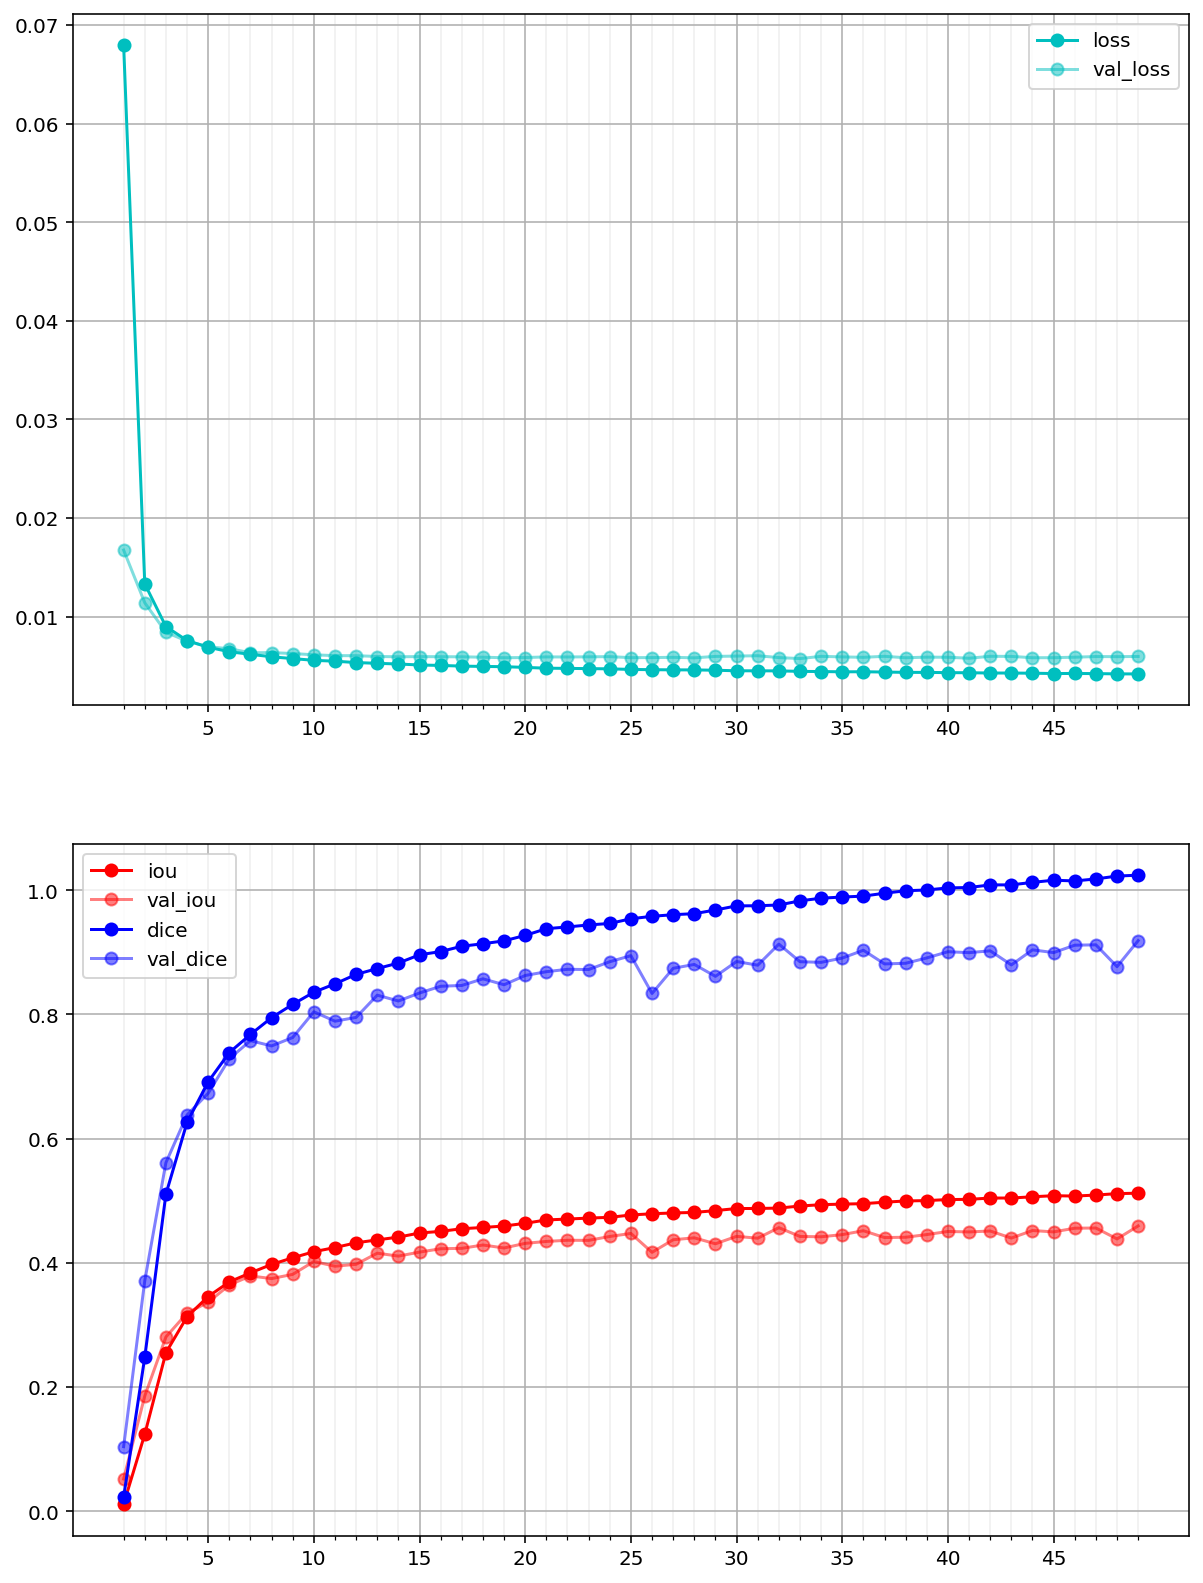

In [23]:
plot_history('/home/rt2122/Models/pz_only_rot/pz_only_rot.ep1-50.history')

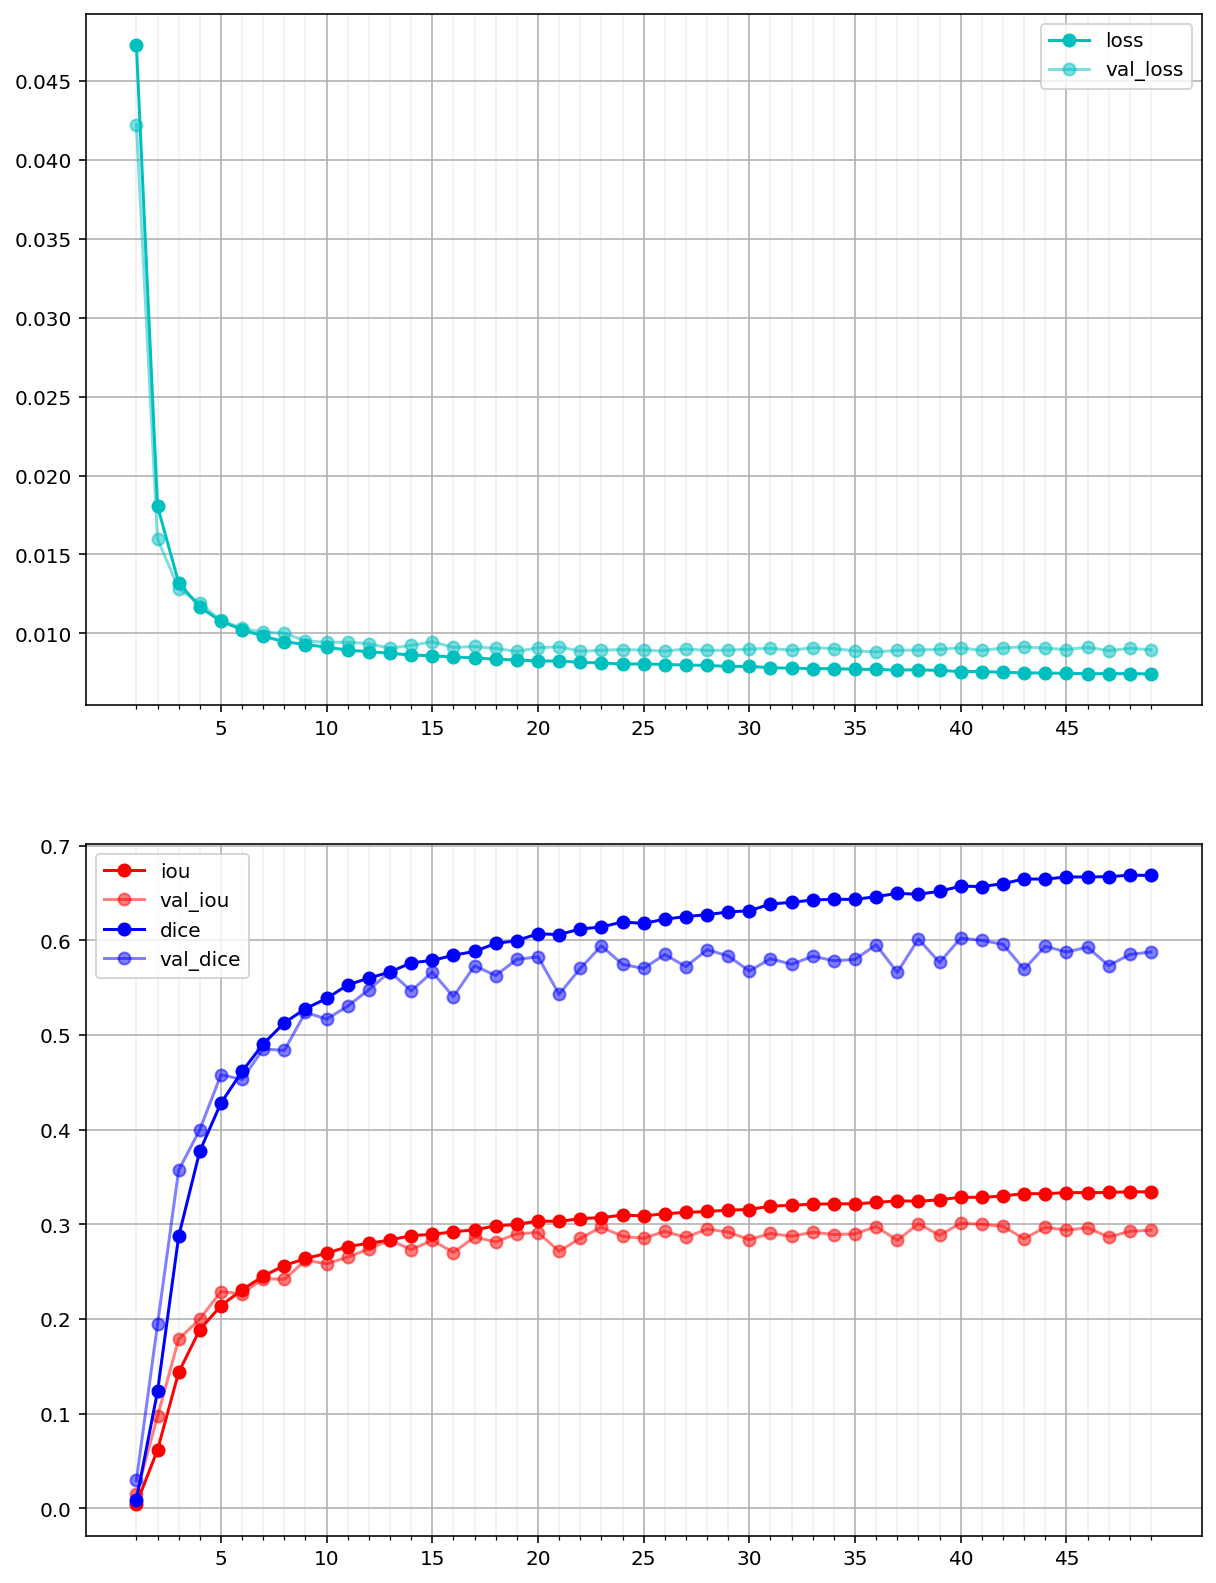

In [9]:
plot_history('/home/rt2122/Models/act_found2/act_found2.ep1-50.history')

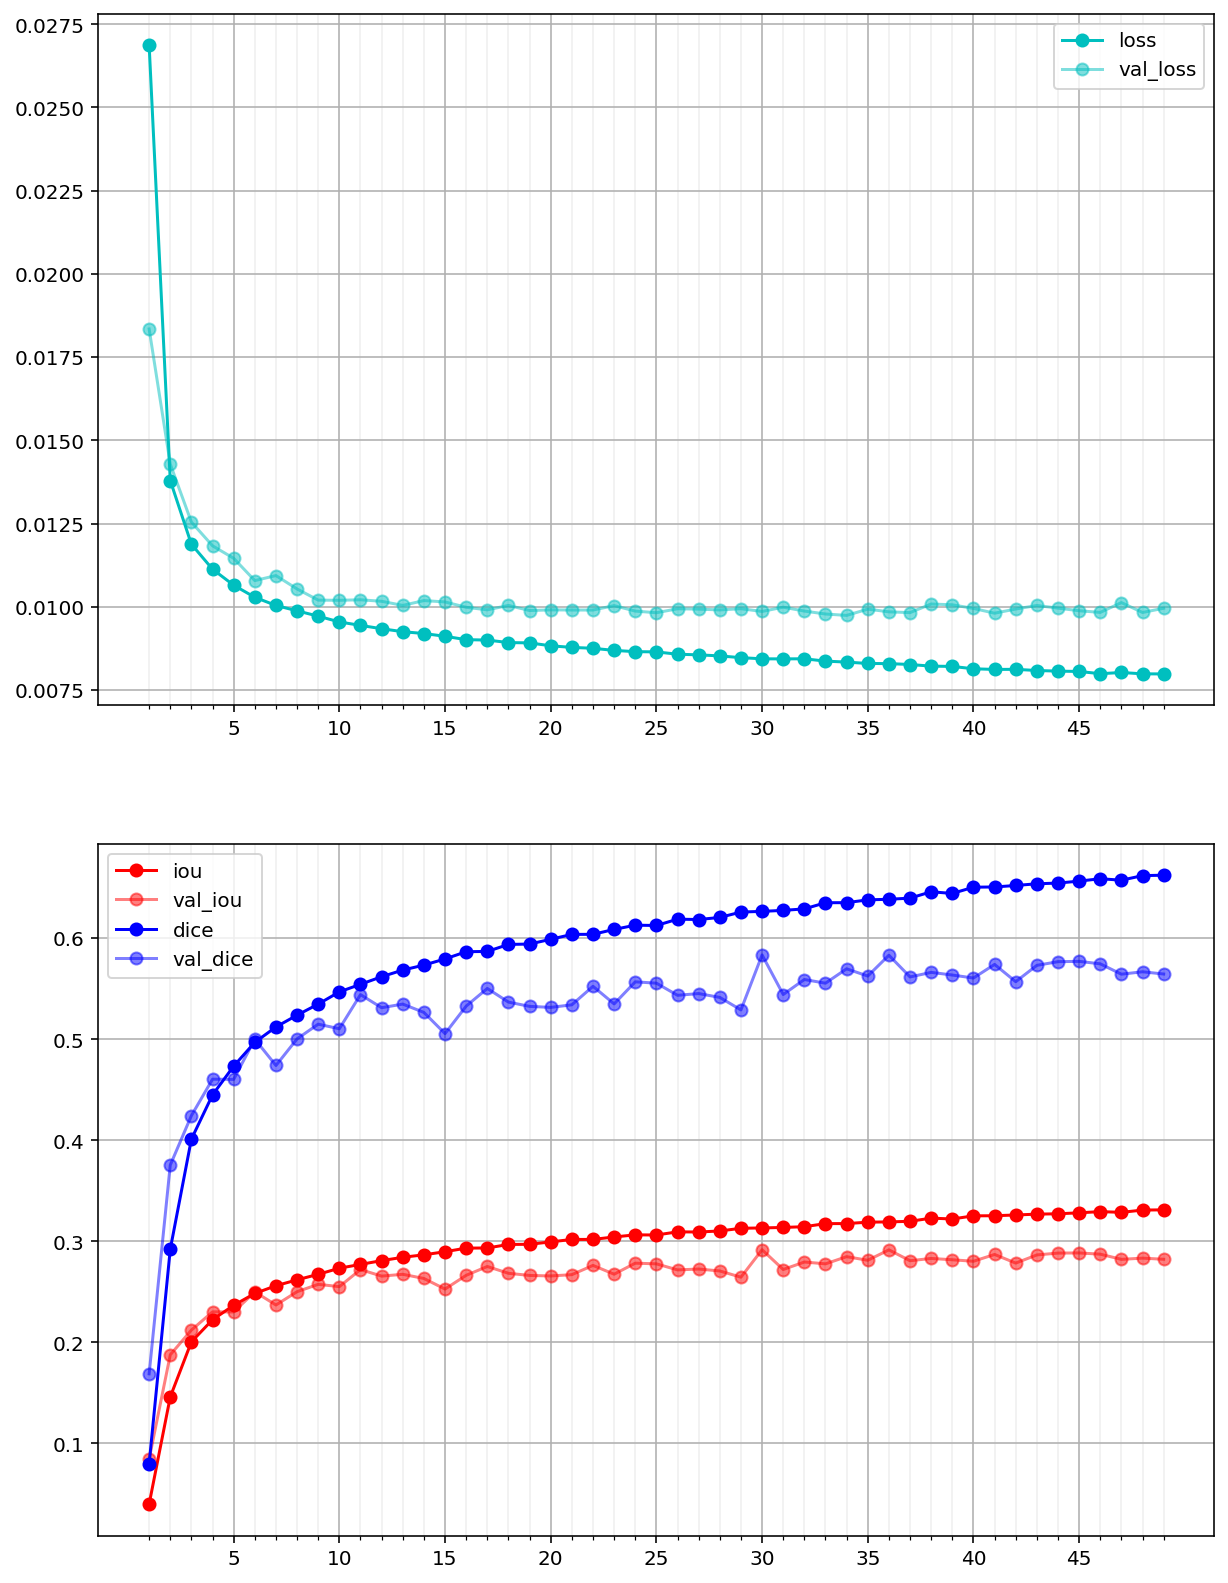

In [24]:
plot_history('/home/rt2122/Models/all_found/all_found.ep1-50.history')

In [36]:
cm = sns.light_palette("green", as_cmap=True)

In [34]:
def draw_map(table, nside=2**9):
    
    hpx_geom = HpxGeom(nside=nside, nest=True, frame='galactic', region=None)
    hpx_map = Map.from_geom(hpx_geom)

    ra = table['RA']
    dec = table['DEC']
    sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    lon = sc.galactic.l.degree
    lat = sc.galactic.b.degree
    for i in tqdm(range(len(lon))):
        hpx_map.set_by_coord((lon[i], lat[i]), vals=-1)

    f, ax = plt.subplots(1, 1, figsize=(16, 8))
    hpx_map.plot(fig=f, cmap=cm)

  0%|          | 0/23331 [00:00<?, ?it/s]

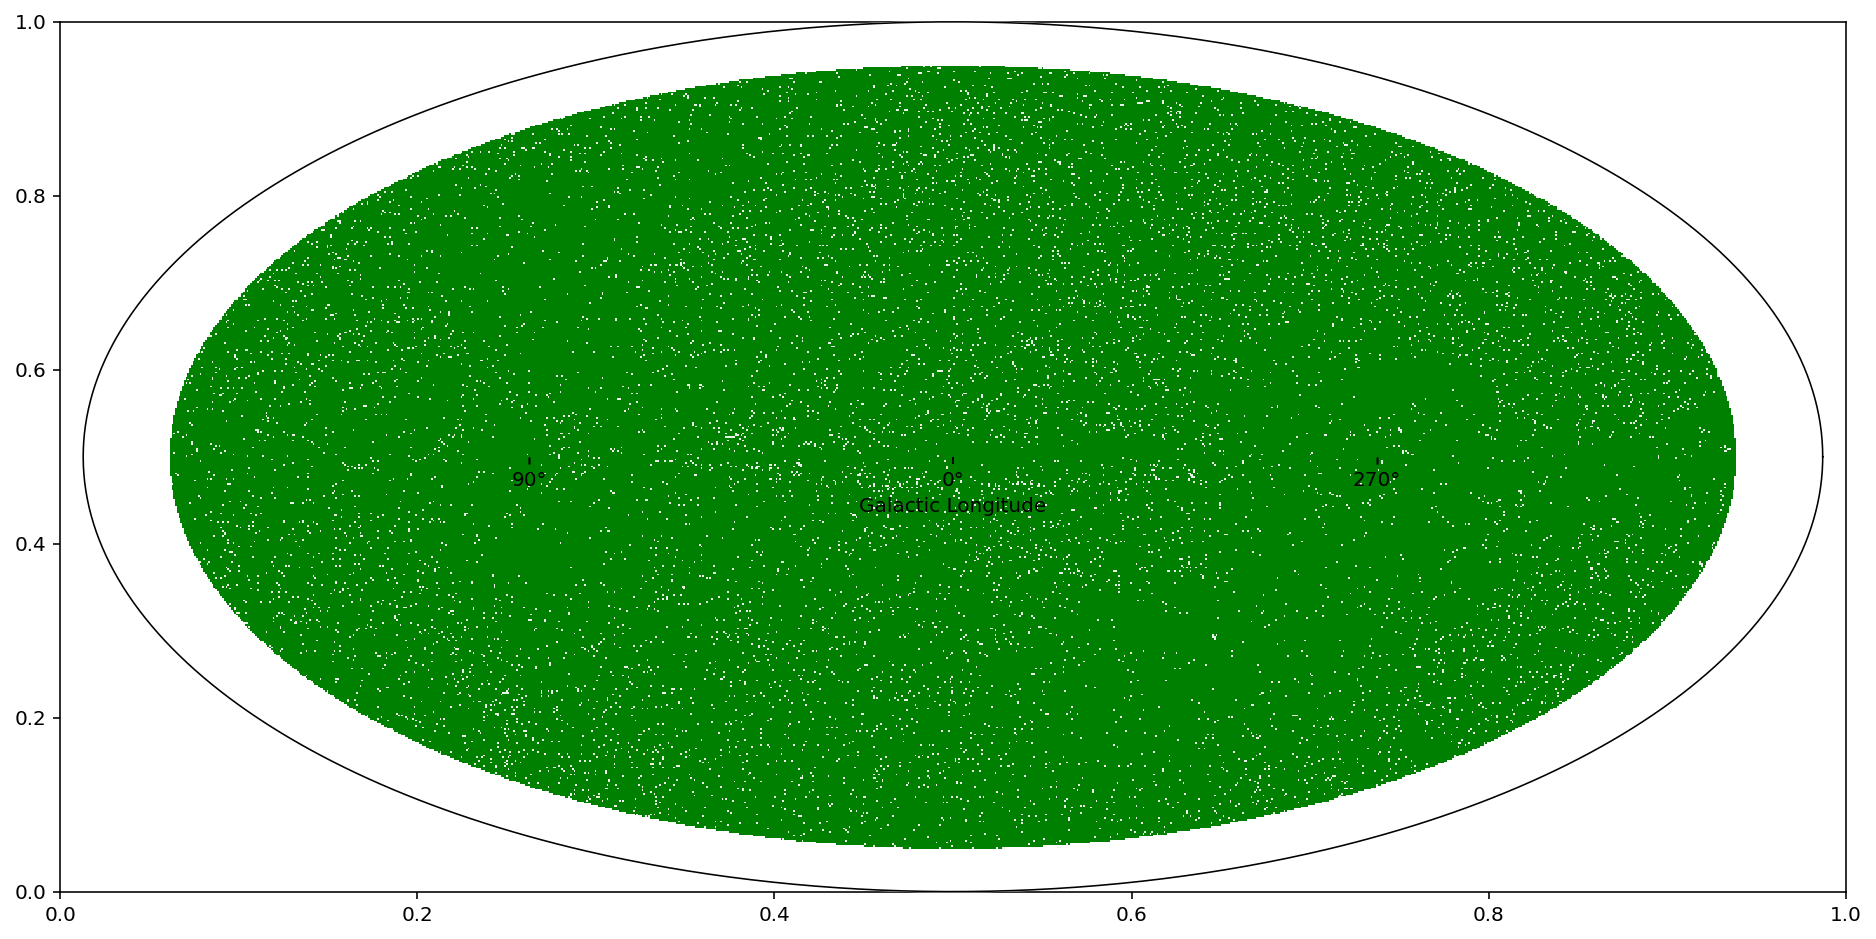

In [37]:
draw_map(cats['pz_rot28'], nside=2**8)

  0%|          | 0/21946 [00:00<?, ?it/s]

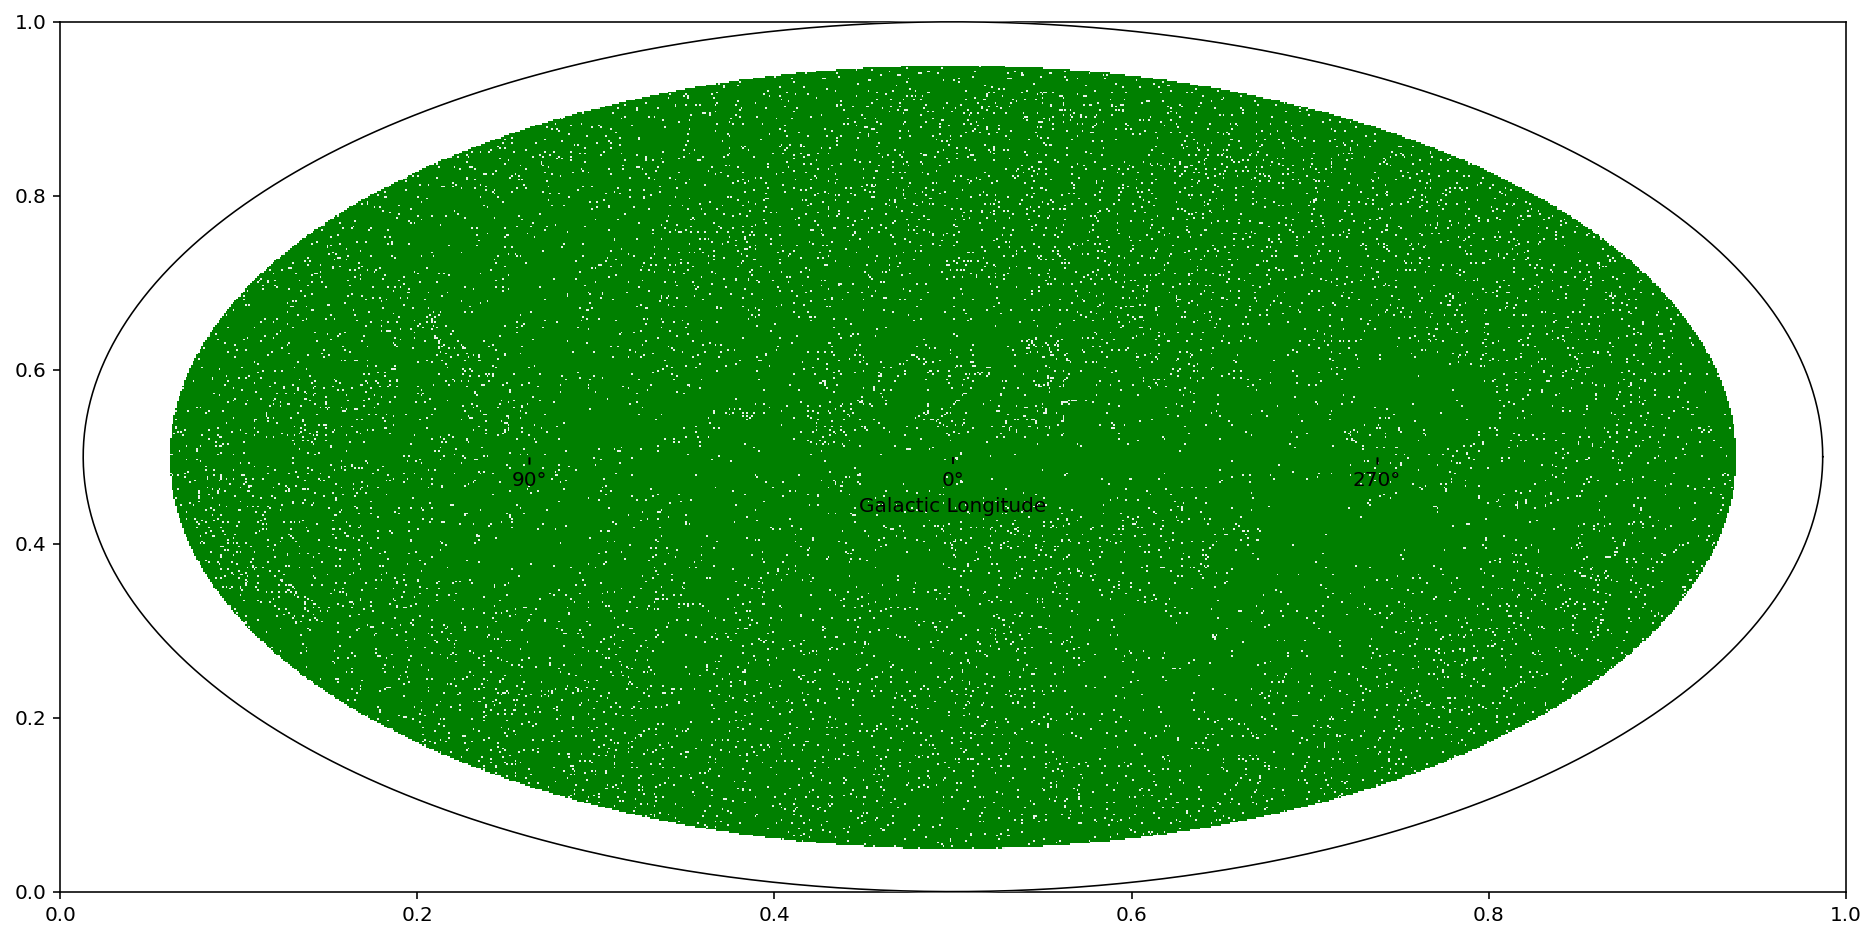

In [38]:
draw_map(cats['pz_act_found2_22'], nside=2**8)

  0%|          | 0/23352 [00:00<?, ?it/s]

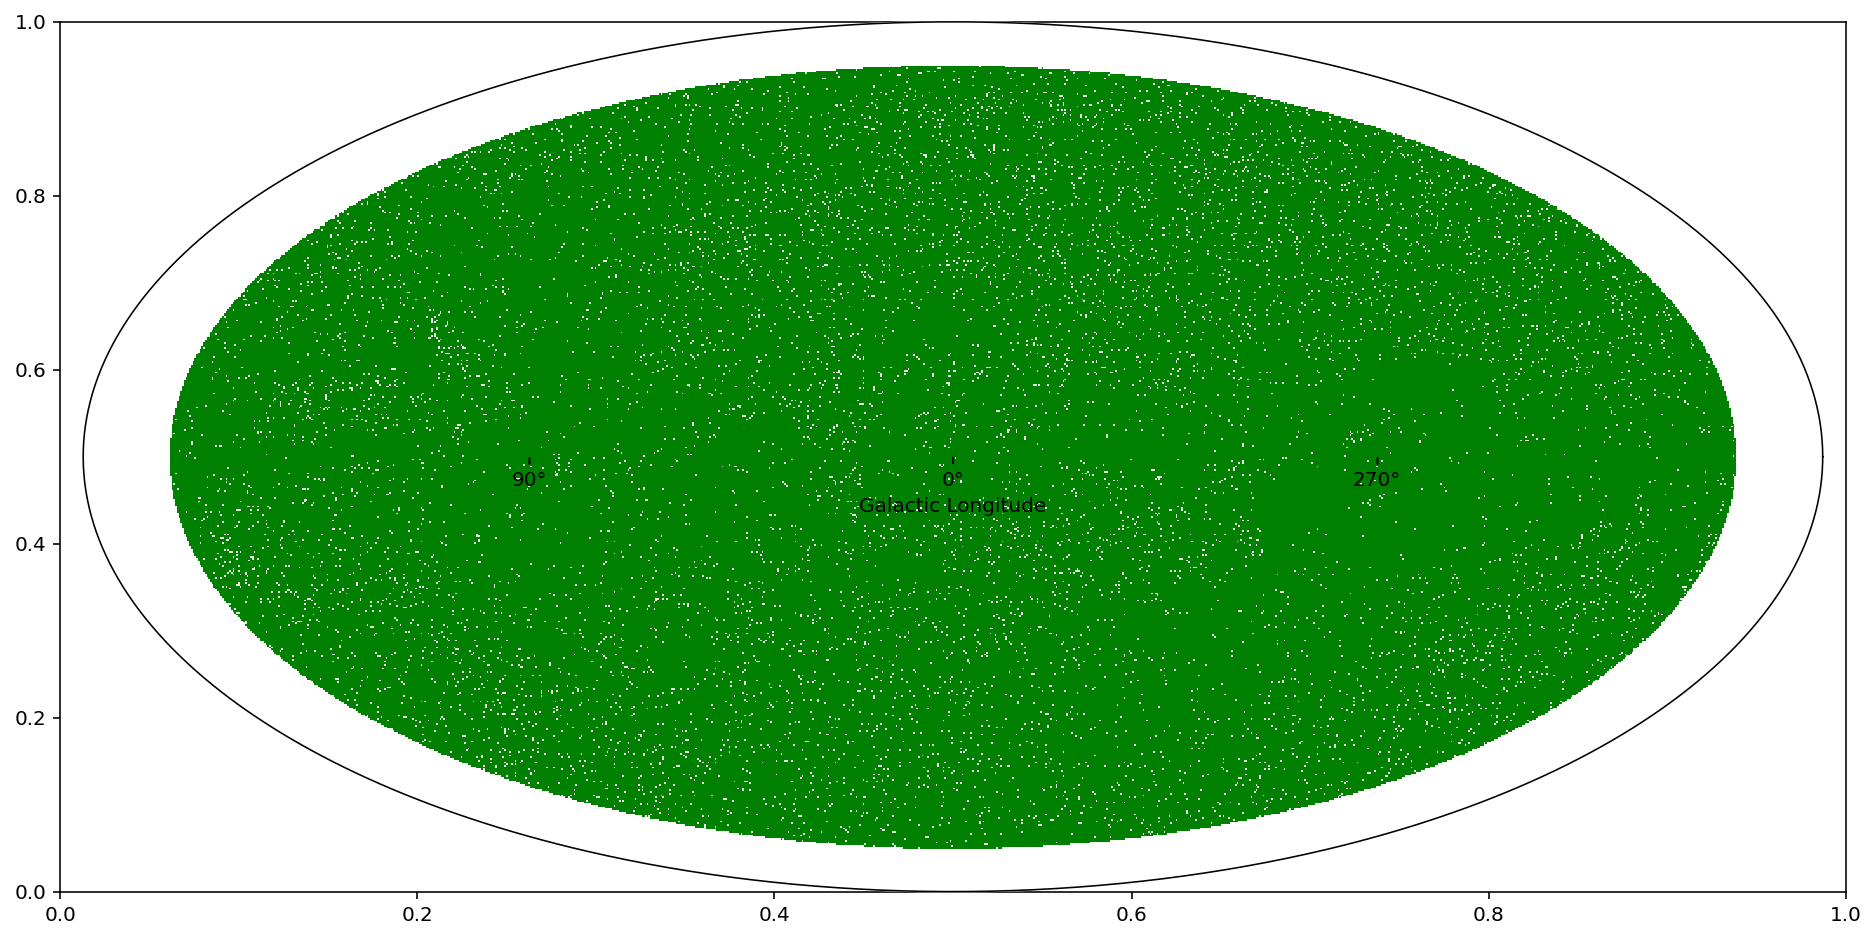

In [39]:
draw_map(cats['pz_all_found34'], nside=2**8)

  0%|          | 0/1094 [00:00<?, ?it/s]

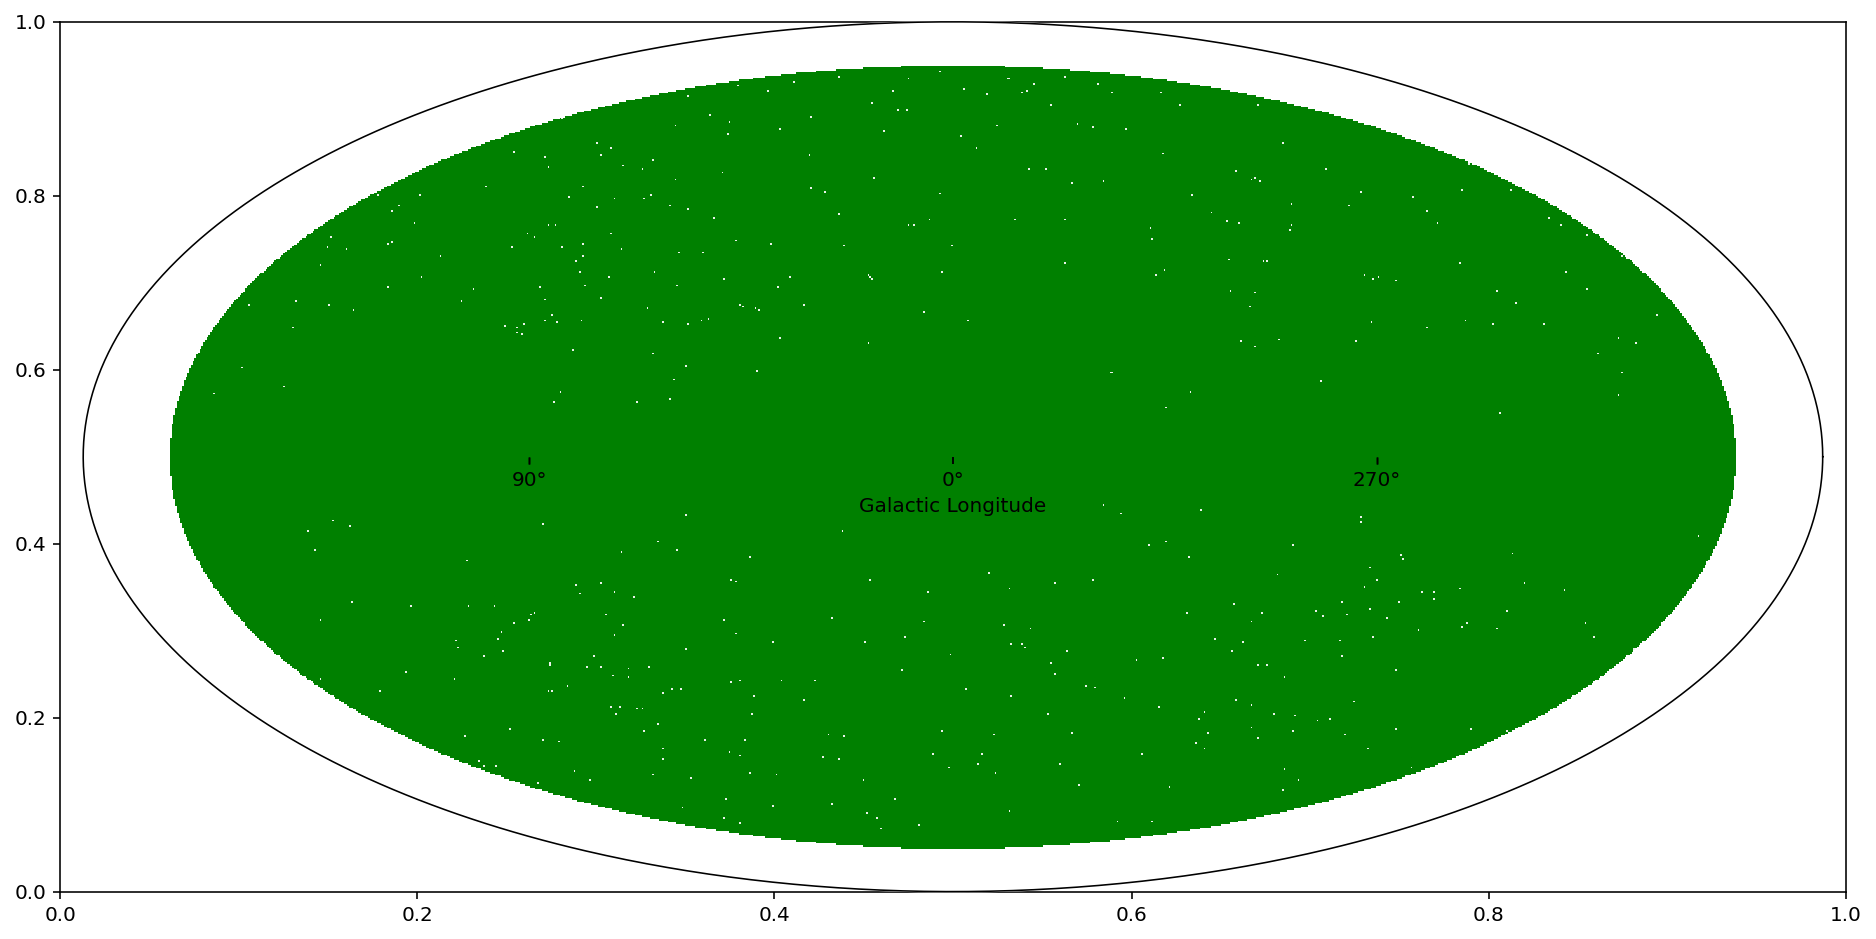

In [41]:
draw_map(pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'), nside=2**8)

/home/rt2122/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


  0%|          | 0/1630 [00:00<?, ?it/s]

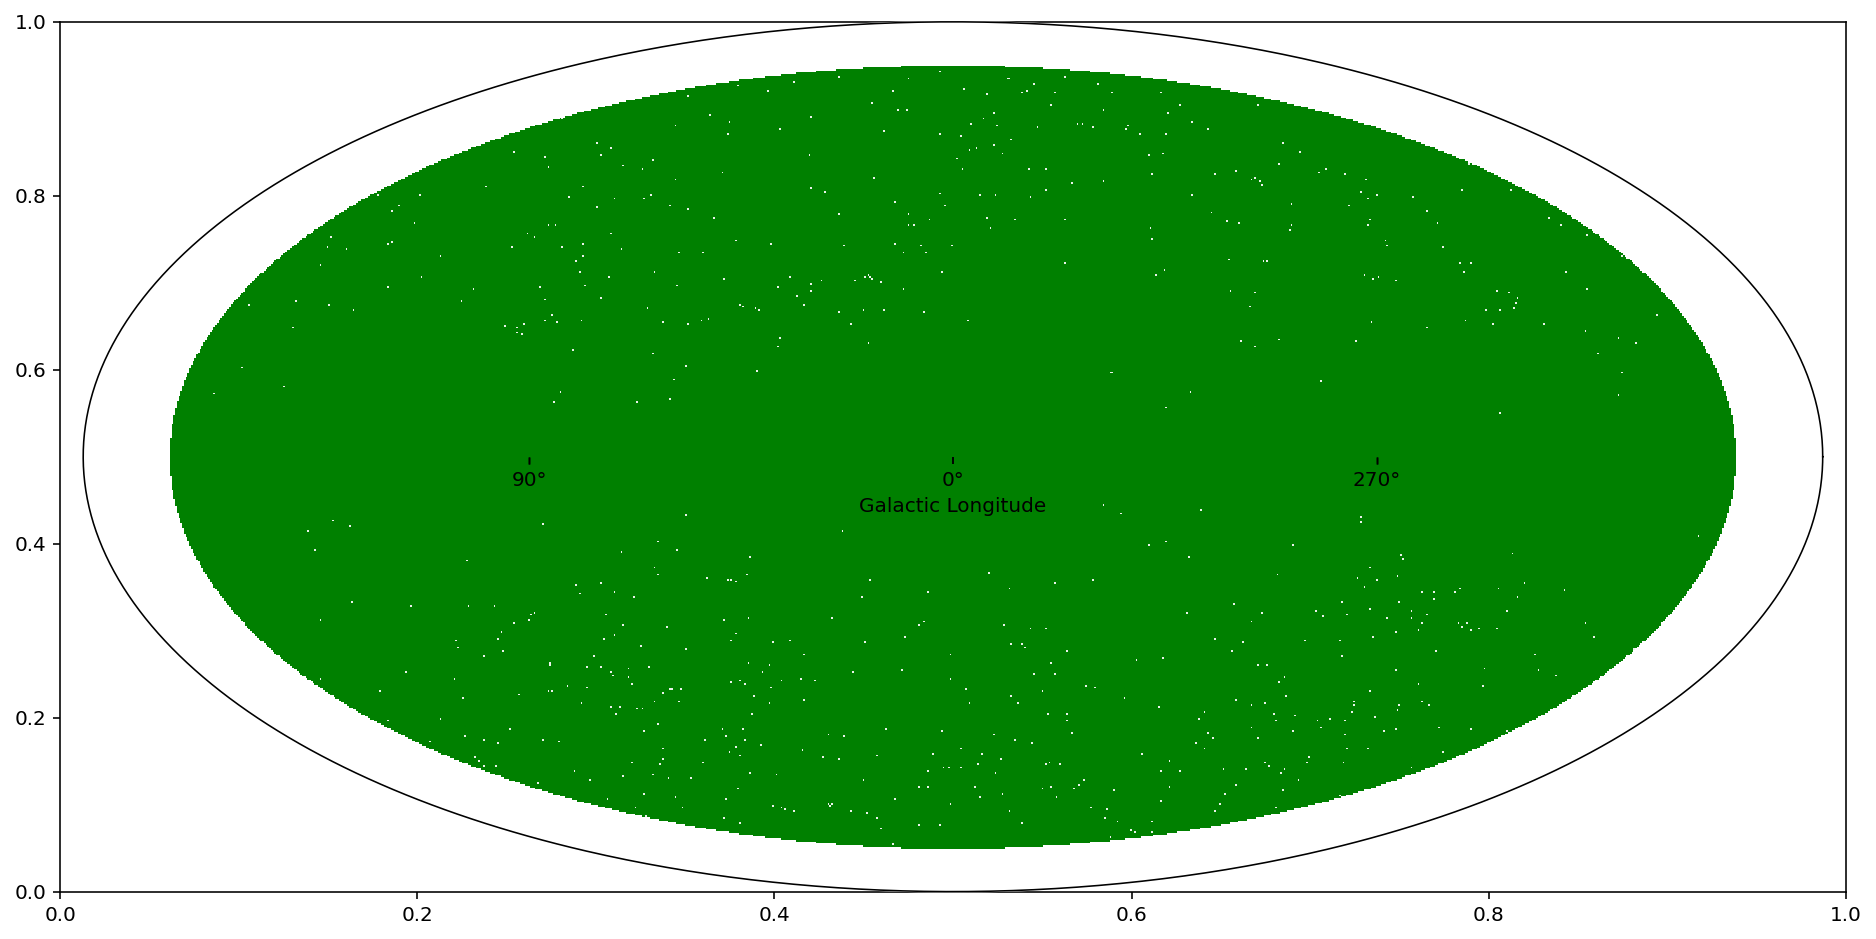

In [42]:
draw_map(pd.concat([pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'), 
                    pd.read_csv('/home/rt2122/Data/clusters/acts/act_found_pz_rot_28.csv')]), nside=2**8)

/home/rt2122/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


  0%|          | 0/2343 [00:00<?, ?it/s]

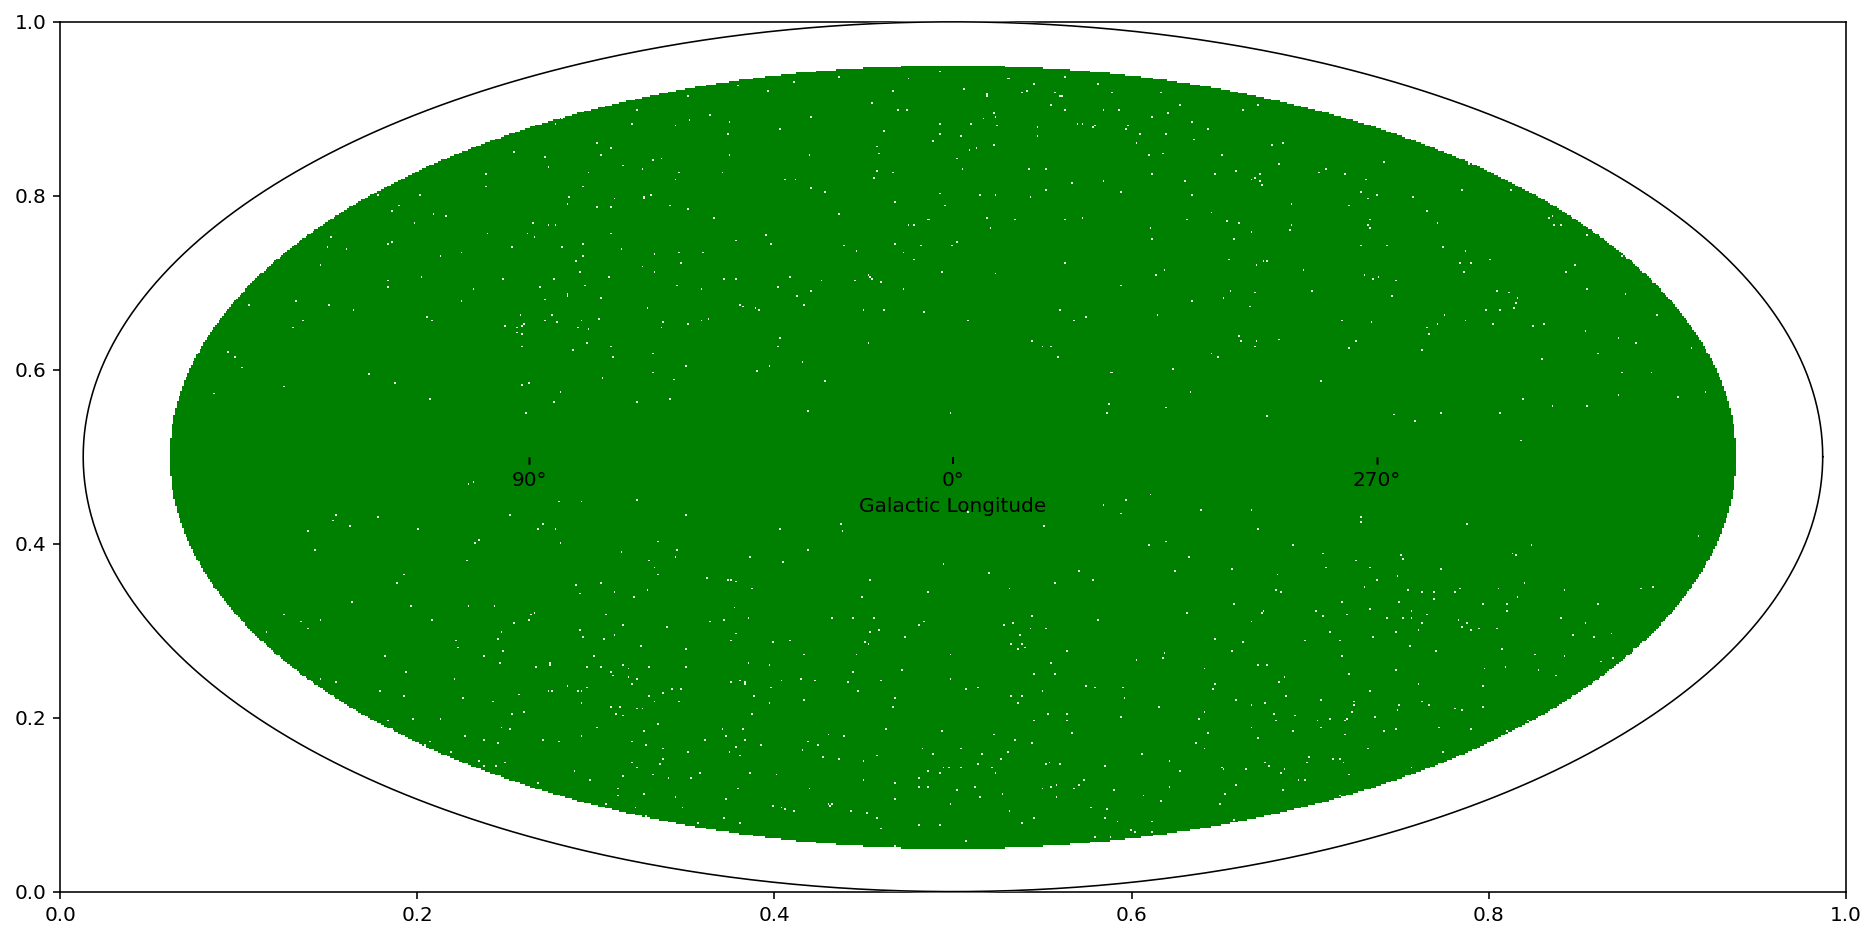

In [43]:
draw_map(pd.concat([pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'), 
                    pd.read_csv('/home/rt2122/Data/clusters/acts/all_found.csv')]), nside=2**8)

In [44]:
patches = pd.read_csv('/home/rt2122/Data/Planck/coords/pz_only_patches.csv')
list(patches)

['x', 'y', 'pix']

In [46]:
ra, dec=pix2radec(patches['pix'], 2**11)
patches['RA'] = ra
patches['DEC'] = dec

  0%|          | 0/3665333 [00:00<?, ?it/s]

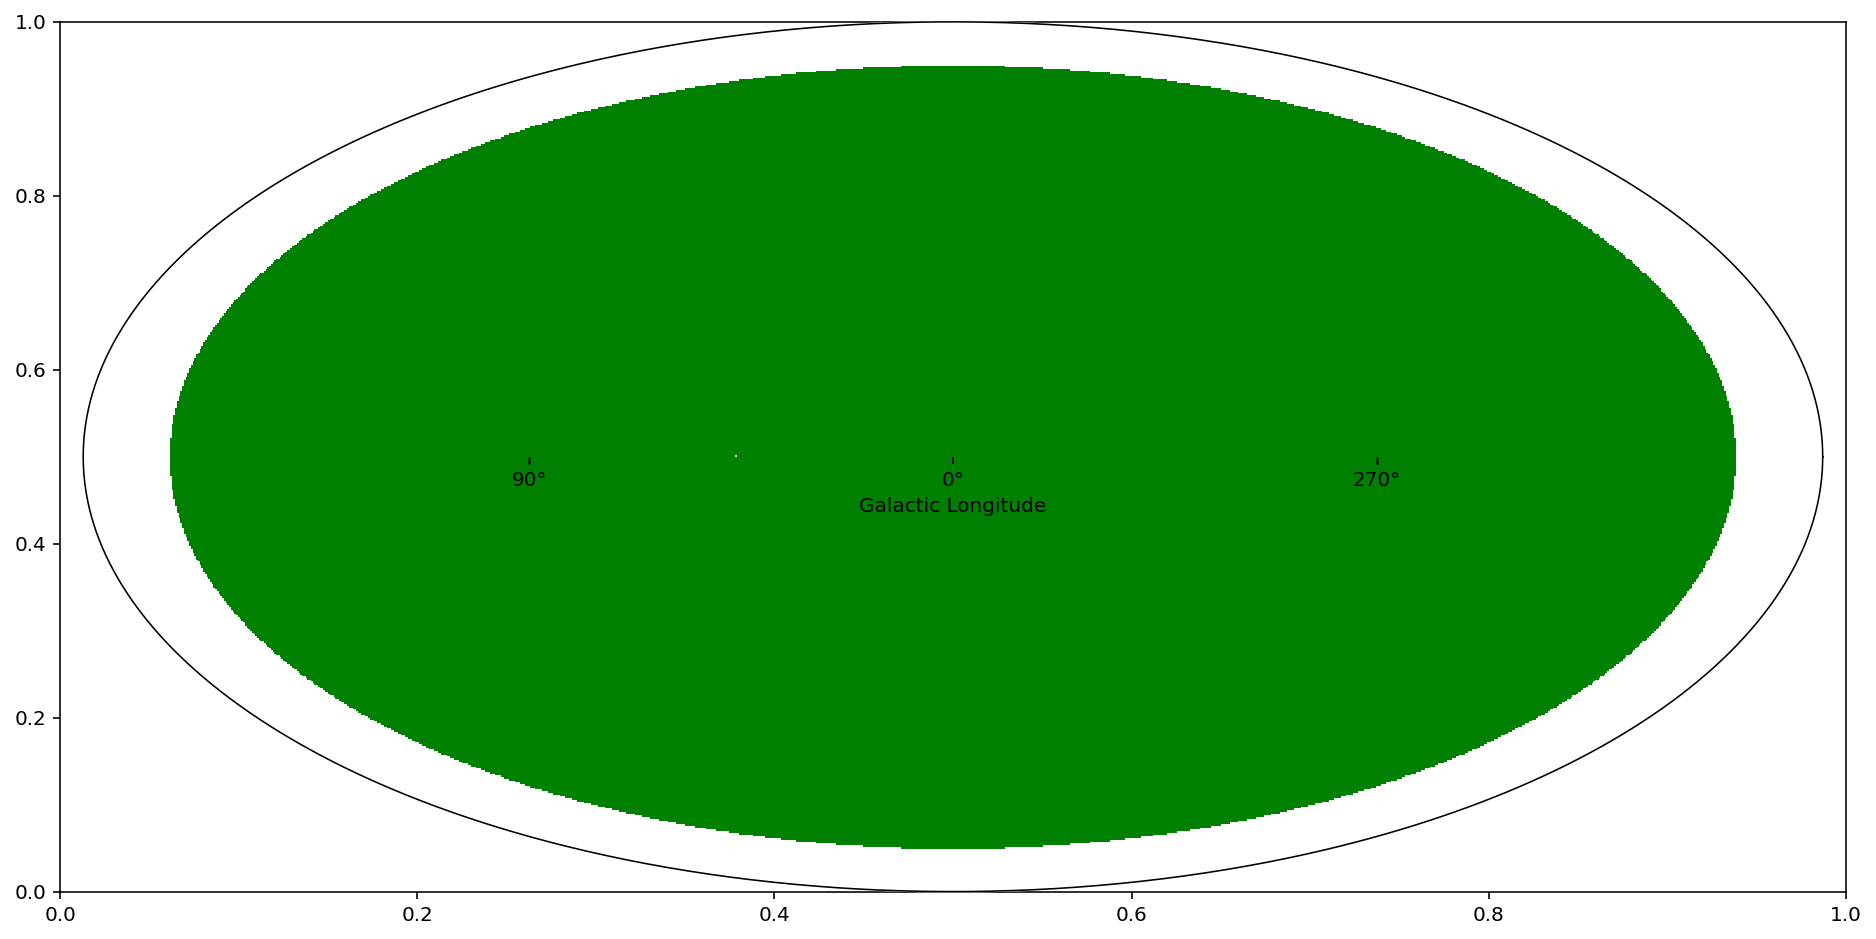

In [47]:
draw_map(patches, 2**8)